In [3]:
using JuMP, Gurobi, CSV, DataFrames, Plots
include("formulation.jl");

### Plottings

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 556 rows, 504 columns and 2376 nonzeros
Model fingerprint: 0x4c397a65
Variable types: 0 continuous, 504 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e+00, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 1716995.0000
Presolve removed 147 rows and 136 columns
Presolve time: 0.00s
Presolved: 409 rows, 368 columns, 1825 nonzeros
Variable types: 0 continuous, 368 integer (0 binary)
Found heuristic solution: objective 1651495.0000

Root relaxation: objective 1.031664e+06, 64 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumben

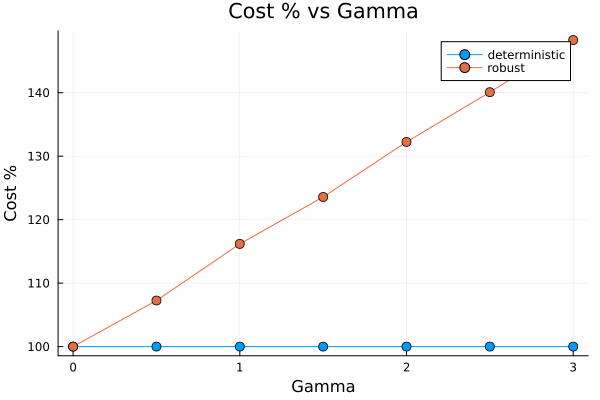

In [40]:
deterministic_cost = []
robust_cost = []

for Gamma in [0,0.5,1,1.5,2,2.5,3]
    a,b,c,d, obj_blue = optimize_red()
    a,b,c,d, obj_robust = optimize_red_robust(Gamma)
    push!(deterministic_cost, obj_blue)
    push!(robust_cost, obj_robust)
end

robust_cost = robust_cost./ deterministic_cost[1] .* 100
deterministic_cost = deterministic_cost./ deterministic_cost[1] .* 100

plot([0,0.5,1,1.5,2,2.5,3], deterministic_cost, label="deterministic", xlabel="Gamma", ylabel="Cost %", title="Cost % vs Gamma", marker=(:circle,5))
plot!([0,0.5,1,1.5,2,2.5,3], robust_cost, label="robust", marker=(:circle,5))

In [133]:
function optimize_blue(number_trains)

    cost_blue = 2000;
    capacity_blue = 300;
    q=5;
    stations_b, times, directions = size(AvgFlowBlue);

    modelBlue = Model(Gurobi.Optimizer)
    
    @variable(modelBlue, x[1:directions, 1:times] >= 0, Int)
    @variable(modelBlue, u[1:directions, 1:times, 1:stations_b] >= 0, Int)
    @variable(modelBlue, s[1:directions, 1:times] >= 0, Int)
    @variable(modelBlue, r[1:directions, 1:times] >= 0, Int)

    @constraint(modelBlue, [d=1:directions, j=2:times, i=1:stations_b], 
        u[d,j,i] + capacity_blue * (x[d,j] + s[d,j]) >= AvgFlowBlue[i,j,d] + u[d,j-1,i])
    @constraint(modelBlue, [d=1:directions, i=1:stations_b], 
        u[d,1,i] + capacity_blue * (x[d,1] + s[d,1]) >= AvgFlowBlue[i,1,d])
    #@constraint(modelBlue,  [d=1:directions,  i=1:stations_b], u[d,9,i] == 0 )

    @constraint(modelBlue,  r[2,1] ==   x[1,1] )
    @constraint(modelBlue,  r[1,1] ==  x[2,1]  ) 
    @constraint(modelBlue, [j=2:times], r[2,j] ==   x[1,j] +  s[1,j]  - s[2,j] + r[2,j-1])
    @constraint(modelBlue, [j=2:times], r[1,j] ==  x[2,j] +  s[2,j] - s[1,j] + r[1,j-1])

    @constraint(modelBlue, [d=1:directions], s[d,1] == 0)
    @constraint(modelBlue, [d=1:directions, j=2:times], s[d,j] <= r[d,j-1])

    @constraint(modelBlue, [d=1:directions], r[1, times]  >=  x[1,1])
    @constraint(modelBlue, [d=1:directions], r[2, times]  >=  x[2,1])

    @constraint(modelBlue, [j=1:times, d=1:directions], x[d,j] + s[d,j] >= 1)

    @constraint(modelBlue,  sum(x[1,:]) + sum(x[2,:]) <= number_trains)

    @objective(modelBlue, Min, sum(sum(cost_blue * x[d,j] + 0.95 * cost_blue * s[d,j] + 
                sum(q * u[d,j,i] for i=1:stations_b) for d=1:directions) for j=1:times))

    optimize!(modelBlue)

    return value.(x), value.(s), value.(r), value.(u), objective_value(modelBlue)
end

optimize_blue (generic function with 3 methods)

In [134]:
x,s,r,u,d  = optimize_blue(2)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 275 rows, 270 columns and 1020 nonzeros
Model fingerprint: 0x14370821
Variable types: 0 continuous, 270 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [5e+00, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 275 rows and 270 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 8.45598e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.455975000000e+06, best bound 8.455975000000e+06, gap 0.0000%

User-callback calls 362, time in user-callback 0.00 sec


([1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0], [0.0 1.0 … 1.0 1.0; 0.0 1.0 … 1.0 1.0], [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [1415.0 3964.0 … 22863.0 22620.0; -0.0 -0.0 … 16624.0 16732.0;;; 1659.0 4833.0 … 28617.0 28383.0; -0.0 225.0 … 30399.0 30864.0;;; 751.0 2033.0 … 10526.0 10248.0; -0.0 -0.0 … 7953.0 7833.0;;; … ;;; 805.0 2210.0 … 11250.0 10973.0; -0.0 -0.0 … 11144.0 11106.0;;; 265.0 809.0 … 4287.0 4007.0; -0.0 -0.0 … -0.0 -0.0;;; 1220.0 3319.0 … 17361.0 17090.0; -0.0 -0.0 … 15032.0 15090.0], 8.455975e6)

In [135]:
x

2×9 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [136]:
r

2×9 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [137]:
s

2×9 Matrix{Float64}:
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0